# Existence of Local Market Inefficiencies in local currency exchange desks

### Gather and load FX rates from the several local brick-and-mortar FX desks

In [1]:
# Import prerequisites
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


import warnings

In [2]:
# Load data
shop_a_rates = pd.read_csv("fx_data/shop_a.csv")    # Kowloon region
shop_b_rates = pd.read_csv("fx_data/shop_b.csv")    # Kowloon region
shop_c_rates = pd.read_csv("fx_data/shop_c.csv")    # Kowloon region

In [3]:
# Rename columns 
shop_a_rates.rename(columns={"buy_price": "shop_a_buy", "sell_price": "shop_a_sell"}, inplace=True) # Shop A

shop_b_rates.rename(columns={"buy_price": "shop_b_buy", "sell_price": "shop_b_sell"}, inplace=True) # Shop B

shop_c_rates.rename(columns={"buy_price": "shop_c_buy", "sell_price": "shop_c_sell"}, inplace=True) # Shop C

In [4]:
# Merge rates
merged_rates = pd.merge(shop_a_rates, shop_b_rates, on=["pair_label", "date_label"])
merged_rates = pd.merge(merged_rates, shop_c_rates, on=["pair_label", "date_label"])

merged_rates.rename(columns={"date_label": "date", "pair_label": "pair"}, inplace=True)

merged_rates

,date,pair,shop_a_buy,shop_a_sell,shop_b_buy,shop_b_sell,shop_c_buy,shop_c_sell
0,2024-06-28,HKD-AED,1.9200,2.19000,2.10000,2.16000,2.1000,2.1300
1,2024-06-28,HKD-AUD,5.0300,5.29000,5.14000,5.21000,5.1100,5.2000
2,2024-06-28,HKD-CAD,5.5600,5.81000,5.67000,5.75000,5.6300,5.7300
3,2024-06-28,HKD-CHF,8.3100,8.83000,8.62000,8.72000,8.6200,8.7300
4,2024-06-28,HKD-CNY,0.9470,0.93500,1.05932,1.07066,1.0630,1.0680
5,2024-06-28,HKD-EUR,8.1800,8.45000,8.31000,8.39000,8.2900,8.3700
6,2024-06-28,HKD-GBP,9.6800,9.99000,9.79000,9.93000,9.8000,9.9200
7,2024-06-28,HKD-JPY,0.0475,0.04929,0.04830,0.04890,0.0482,0.0490
8,2024-06-28,HKD-KRW,0.0054,0.00568,0.00555,0.00575,0.0055,0.0057
9,2024-06-28,HKD-MYR,1.6000,1.70500,1.64000,1.70000,1.6400,1.6850


A total of 16 FX pairs were found to be in all 4 datasets. The datasets were filtered to ensure they all had the same 16 FX pairs to ensure consistency. 

As shown above in the table, the buy and sell prices of each shop is represented by a column with each row representing a FX pair. A single day screenshot was taken and 3 shops were included. They have been anonymized for this project. 

In [5]:
# Get available matching pairs
available_pairs = list(merged_rates['pair'].unique())
available_pairs

['HKD-AED',
 'HKD-AUD',
 'HKD-CAD',
 'HKD-CHF',
 'HKD-CNY',
 'HKD-EUR',
 'HKD-GBP',
 'HKD-JPY',
 'HKD-KRW',
 'HKD-MYR',
 'HKD-NZD',
 'HKD-PHP',
 'HKD-SAR',
 'HKD-SGD',
 'HKD-THB',
 'HKD-USD']

We extract all pairs available in the price table for later use for calculating arbitrage opportunities.

In [6]:
# Filter for an FX pair
merged_rates.loc[merged_rates['pair'] == "HKD-JPY"]

,date,pair,shop_a_buy,shop_a_sell,shop_b_buy,shop_b_sell,shop_c_buy,shop_c_sell
7,2024-06-28,HKD-JPY,0.0475,0.04929,0.0483,0.0489,0.0482,0.049


The above line is used to filter out a row in the price table based on the selected FX trading pair. 

### Calculate arbitrage opportunities within the localized market

In [7]:
# Get best arbitrage opportunity for a pair
def get_best_rates(pair):

    # Note: buy and sell are reversed because SHOPS SELL and you BUY. You're goal is to BUY at LOWEST price and SELL at HIGHEST

    # Filter merged rates to be buy or sell
    shop_sell_rates = merged_rates[['shop_a_sell', 'shop_b_sell', 'shop_c_sell']]
    shop_buy_rates = merged_rates[['shop_a_buy', 'shop_b_buy', 'shop_c_buy']]

    # Rename shop column names to be less confusing
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        shop_sell_rates.rename(columns={"shop_a_sell": "shop_a", "shop_b_sell": "shop_b", "shop_c_sell": "shop_c"}, inplace=True)
        shop_buy_rates.rename(columns={"shop_a_buy": "shop_a", "shop_b_buy": "shop_b", "shop_c_buy": "shop_c"}, inplace=True)


    # Calculate
    lowest_buy_shop = shop_sell_rates.loc[merged_rates['pair'] == pair].min().idxmin()
    lowest_buy = shop_sell_rates.loc[merged_rates['pair'] == pair].min().min()

    highest_sell_shop = shop_buy_rates.loc[merged_rates['pair'] == pair].max().idxmax()
    highest_sell = shop_buy_rates.loc[merged_rates['pair'] == pair].max().max()

    difference = highest_sell - lowest_buy

    return lowest_buy_shop, lowest_buy, highest_sell_shop, highest_sell, difference

In [8]:
# Get most profitable opportunities for each pair
for pair in available_pairs:
    print(pair, get_best_rates(pair))

HKD-AED ('shop_c', 2.13, 'shop_b', 2.1, -0.029999999999999805)
HKD-AUD ('shop_c', 5.2, 'shop_b', 5.14, -0.0600000000000005)
HKD-CAD ('shop_c', 5.73, 'shop_b', 5.67, -0.0600000000000005)
HKD-CHF ('shop_b', 8.72, 'shop_b', 8.62, -0.10000000000000142)
HKD-CNY ('shop_a', 0.935, 'shop_c', 1.063, 0.1279999999999999)
HKD-EUR ('shop_c', 8.37, 'shop_b', 8.31, -0.05999999999999872)
HKD-GBP ('shop_c', 9.92, 'shop_c', 9.8, -0.11999999999999922)
HKD-JPY ('shop_b', 0.0489, 'shop_b', 0.0483, -0.0005999999999999964)
HKD-KRW ('shop_a', 0.00568, 'shop_b', 0.00555, -0.0001299999999999999)
HKD-MYR ('shop_c', 1.685, 'shop_b', 1.64, -0.04500000000000015)
HKD-NZD ('shop_c', 4.77, 'shop_b', 4.69, -0.07999999999999918)
HKD-PHP ('shop_c', 0.1345, 'shop_b', 0.13, -0.004500000000000004)
HKD-SAR ('shop_c', 2.09, 'shop_c', 2.05, -0.040000000000000036)
HKD-SGD ('shop_c', 5.78, 'shop_b', 5.71, -0.07000000000000028)
HKD-THB ('shop_c', 0.215, 'shop_c', 0.212, -0.0030000000000000027)
HKD-USD ('shop_c', 7.8, 'shop_c', 7.

After creating a function to calculate the best prices and the maximum profit for a target FX pair, we print the results by iterating through each currency pair in the price table.

It seems for the date 2024-06-28, there are no currency pairs that allow a profitable arbitrage opportunity. This does hint that there could be an existent inefficient local market. There is a slight variation in the exchange rate as well for both buy and sell, which is different than the midmarket rate shown in later sections of the notebook. However, this does end up indicating whether the market is inefficient or efficient as a spread is established for profit margins and risk.

### Compare market rates with local FX shop rates

In [9]:
# Import FX price data
market_rates = pd.read_csv("fx_data/market_rates.csv")

market_rates

,date_label,pair_label,market_price
0,2024-06-28,HKD-AED,2.12635
1,2024-06-28,HKD-AUD,5.19130
2,2024-06-28,HKD-CAD,5.70260
3,2024-06-28,HKD-CHF,8.69519
4,2024-06-28,HKD-CNY,1.07431
5,2024-06-28,HKD-EUR,8.36157
6,2024-06-28,HKD-GBP,9.87990
7,2024-06-28,HKD-JPY,0.04858
8,2024-06-28,HKD-KRW,0.00563
9,2024-06-28,HKD-MYR,1.65464


We need to pull the data for the midmarket rates to compare with the local FX shop rates. 

#### Midmarket Rates?
Midmarket rates are the rates that are calculated by merging buy and sell prices together. No FX platform or trading desk can give the midmarket rate as it is mostly only an indicator of the fair value of the traded currency pair.

In [10]:
# Merge market rates with local rates

market_rates.rename(columns={"pair_label": "pair", "date_label": "date"}, inplace=True)   # Rename label to match merged rates df

merged_rates = pd.merge(merged_rates, market_rates, on=["date", "pair"])
merged_rates

,date,pair,shop_a_buy,shop_a_sell,shop_b_buy,shop_b_sell,shop_c_buy,shop_c_sell,market_price
0,2024-06-28,HKD-AED,1.9200,2.19000,2.10000,2.16000,2.1000,2.1300,2.12635
1,2024-06-28,HKD-AUD,5.0300,5.29000,5.14000,5.21000,5.1100,5.2000,5.19130
2,2024-06-28,HKD-CAD,5.5600,5.81000,5.67000,5.75000,5.6300,5.7300,5.70260
3,2024-06-28,HKD-CHF,8.3100,8.83000,8.62000,8.72000,8.6200,8.7300,8.69519
4,2024-06-28,HKD-CNY,0.9470,0.93500,1.05932,1.07066,1.0630,1.0680,1.07431
5,2024-06-28,HKD-EUR,8.1800,8.45000,8.31000,8.39000,8.2900,8.3700,8.36157
6,2024-06-28,HKD-GBP,9.6800,9.99000,9.79000,9.93000,9.8000,9.9200,9.87990
7,2024-06-28,HKD-JPY,0.0475,0.04929,0.04830,0.04890,0.0482,0.0490,0.04858
8,2024-06-28,HKD-KRW,0.0054,0.00568,0.00555,0.00575,0.0055,0.0057,0.00563
9,2024-06-28,HKD-MYR,1.6000,1.70500,1.64000,1.70000,1.6400,1.6850,1.65464


After merging the midmarket rate ("market_price") into the price table, we notice at a glance that the rate is quite favourable for one party in some cases. Let's dive deeper and see how much opportunity there is.

In [11]:
# Comparing discrepancies in pair pricing to show market efficiency

# Calculate differences in prices
shops = ["shop_a_buy", "shop_a_sell", "shop_b_buy", "shop_b_sell", "shop_c_buy", "shop_c_sell"]

shop_pl = pd.DataFrame({'date': merged_rates['date'], 'pair': merged_rates['pair']})

for shop in shops:

    if "buy" in shop:   # Determine which formula to profit profitability for local shop
        shop_pl[shop] = merged_rates['market_price'] - merged_rates[shop]
    else:
        shop_pl[shop] = merged_rates[shop] - merged_rates['market_price'] 

shop_pl.style.background_gradient()

,date,pair,shop_a_buy,shop_a_sell,shop_b_buy,shop_b_sell,shop_c_buy,shop_c_sell
0,2024-06-28,HKD-AED,0.206350,0.063650,0.026350,0.033650,0.026350,0.003650
1,2024-06-28,HKD-AUD,0.161300,0.098700,0.051300,0.018700,0.081300,0.008700
2,2024-06-28,HKD-CAD,0.142600,0.107400,0.032600,0.047400,0.072600,0.027400
3,2024-06-28,HKD-CHF,0.385190,0.134810,0.075190,0.024810,0.075190,0.034810
4,2024-06-28,HKD-CNY,0.127310,-0.139310,0.014990,-0.003650,0.011310,-0.006310
5,2024-06-28,HKD-EUR,0.181570,0.088430,0.051570,0.028430,0.071570,0.008430
6,2024-06-28,HKD-GBP,0.199900,0.110100,0.089900,0.050100,0.079900,0.040100
7,2024-06-28,HKD-JPY,0.001080,0.000710,0.000280,0.000320,0.000380,0.000420
8,2024-06-28,HKD-KRW,0.000230,0.000050,0.000080,0.000120,0.000130,0.000070
9,2024-06-28,HKD-MYR,0.054640,0.050360,0.014640,0.045360,0.014640,0.030360


After adding a background gradient based on row values in each column, we notice that profitability is dependent on the rate set for the day and the amount exchanged. There are some pairs which do not end up being profitable if the midmarket price fluctuates and ends up worse than when a shop does its latest price update. 

We notice that several SELL pairs end up losing money, while some are not as profitable as others. It also seems that some strong currencies such as the GBP and CHF have a better margin set for the shop compared to others such as the Yen (JPY) or Won (KRW). Without transactional data, we cannot conclude whether the lower margin is due to the change in midmarket price from the initial set price by the shop, the volume of money that is exchanged for currencies such as the Yen (JPY) or Won (KRW), or another factor.

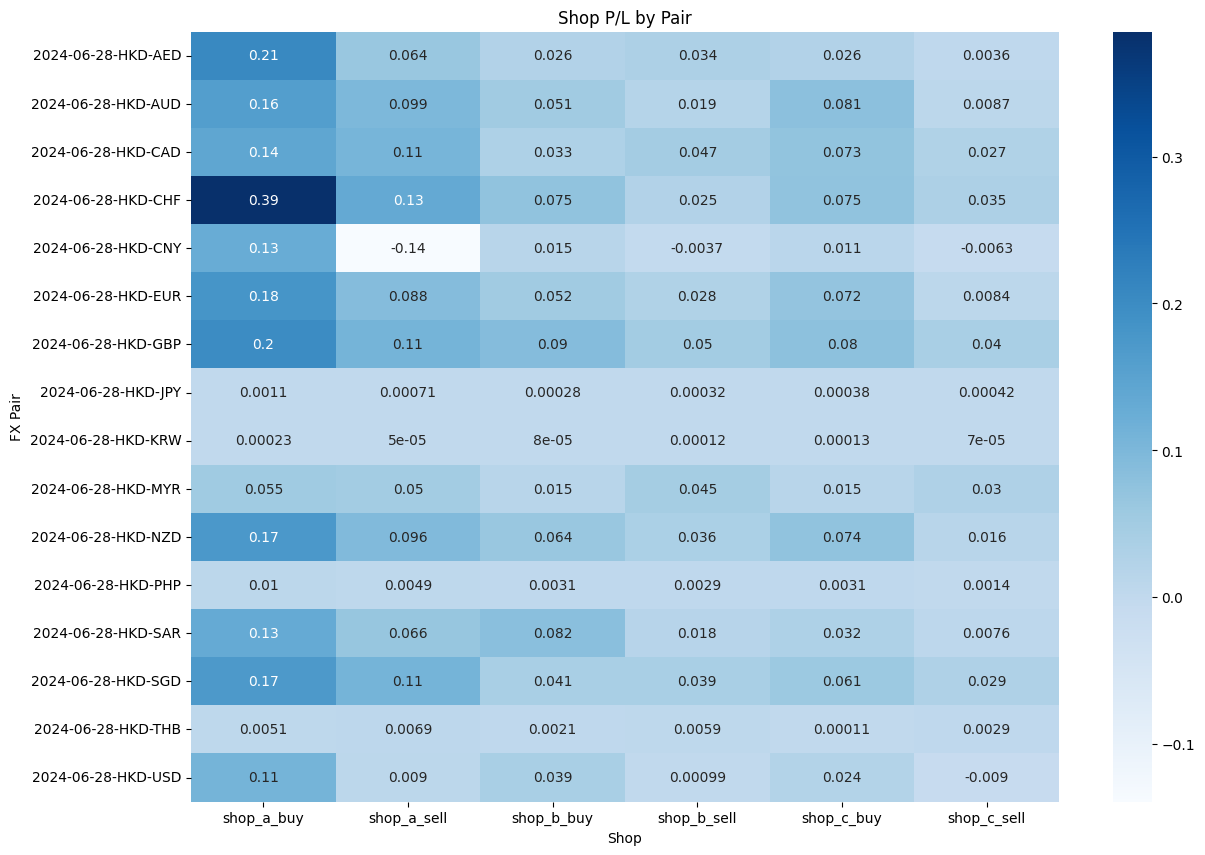

In [12]:
shop_pl.set_index(['date', 'pair'], inplace=True)

plt.figure(figsize=(14, 10))
sns.heatmap(shop_pl, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar=True)

plt.title("Shop P/L by Pair")
plt.xlabel("Shop")
plt.ylabel("FX Pair")

plt.show()

The heatmap shows us the overall opportunities and seems that Swiss Franc (CHF) at Shop A BUY prices would give the best rate for the shop if it were to buy compared to the midmarket rate. Despite having a good rate for Swiss Franc (CHF), it still seems to lose on selling CNY, with Shop A itself taking the most loss compared to Shop B and C. However, all three shops are taking hits and losing on the HKD-CNY pair when selling based on the "snapshot" for the prices compared to the midmarket rate at the "snapshot" time.

### Thoughts

More data would be needed to determine market inefficiencies. A challenge is gathering data from more shops, as there is no central API or dataset for all FX rates for each shop in the Hong Kong SAR. This also does not have data on volumes traded as opposed to FX exchange APIs for large FX brokerages. Without the trading volumes, we cannot understand the extent of the local shops' profitability and volumes to compare with online FX brokers to determine and confirm market inefficiency.  